# Use Altair to visualize large data

## 1. Library import

In [1]:
import numpy as np
import pandas as pd
import altair as alt
# alt.data_transformers.enable('json')  # automatically save chart spec as json


## 2. Experiment: feed data directly to Altair _vs_ Pandas preprocessing + Altair 

In [2]:
def create_2d_gaussian_data(num_of_grids:int):
    ''' create a [num_of_grids] by [num_of_grids] 2d Gaussian-like array
    '''
    # 2d array for x and y
    x,y = np.meshgrid(np.linspace(-1,1,num_of_grids), 
                      np.linspace(-1,1,num_of_grids))
    
    # generate 2d Gaussian-like array
    d_to_center = np.sqrt(x**2 + y**2)
    sigma, mu = 1.0, 0.0
    g = np.exp(-0.5 * (d_to_center-mu)**2 / sigma**2)
    
    # convert to dataframe
    frame = pd.DataFrame()
    frame = frame.assign(x=x.flatten(), y=y.flatten(), g=g.flatten())
    
    return frame

In [3]:
# experiment
for n in range(6):
    n_grid = 100*2**n
    
    # exp_A: feed data directly to Altair
    data = create_2d_gaussian_data(n_grid)
    chart = alt.Chart(data, width=500, height=500).mark_square().encode(
    alt.X('x:Q', bin=alt.Bin(maxbins=100)),
    alt.Y('y:Q', bin=alt.Bin(maxbins=100)),
    alt.Color('sum(g):Q'),
    alt.Tooltip([
        "x:Q",
        "y:Q",
        "sum(g):Q"
        ])
    )
    chart.savechart(f'json/2dGaussian_grid_{n_grid}.json')
    print(f'chart 2dGaussian_grid_{n_grid}.json saved.')
    
    # exp_B: Pandas preprocessing + Altair
    data2 = (data.copy()
             .assign(x_cut=pd.qcut(data.x, 100).apply(lambda x:x.mid))
             .assign(y_cut=pd.qcut(data.y, 100).apply(lambda y:y.mid))
             .groupby(['x_cut','y_cut'])['g'].agg('mean')
             .reset_index()
        )
    chart = alt.Chart(data2, width=500, height=500).mark_square().encode(
    alt.X('x_cut:Q'),
    alt.Y('y_cut:Q'),
    alt.Color('g:Q'),
    alt.Tooltip([
        "x_cut:Q",
        "y_cut:Q",
        "g:Q"
        ])
    )
    chart.save(f'json/2dGaussian_grid_{n_grid}_red.json')
    print(f'chart 2dGaussian_grid_{n_grid}_red.json saved.')
    
    

chart 2dGaussian_grid_100.json saved.
chart 2dGaussian_grid_100_red.json saved.
chart 2dGaussian_grid_200.json saved.
chart 2dGaussian_grid_200_red.json saved.
chart 2dGaussian_grid_400.json saved.
chart 2dGaussian_grid_400_red.json saved.
chart 2dGaussian_grid_800.json saved.
chart 2dGaussian_grid_800_red.json saved.
chart 2dGaussian_grid_1600.json saved.
chart 2dGaussian_grid_1600_red.json saved.
chart 2dGaussian_grid_3200.json saved.
chart 2dGaussian_grid_3200_red.json saved.


In [4]:
# record the json file sizes
!ls -lS json/2dGaussian_grid_*.json | awk '{print $5" "$9}' > file_size.txt

In [5]:
# obtain the file_size dataframe
import re

file_size = pd.read_csv('file_size.txt', sep=' ', names=['file_size','file_name'])
file_size = (file_size.assign( n_grids = file_size.file_name.apply(lambda s: int(re.match('.*_([0-9]+).*json', s).group(1))))
                      .assign(preprocessing = file_size.file_name.apply(lambda x: re.match('.*_red.json', x) is not None))
                      .eval('n_rows = n_grids**2')
            )

In [6]:
file_size

,file_size,file_name,n_grids,preprocessing,n_rows
0,803045698,json/2dGaussian_grid_3200.json,3200,False,10240000
1,200814320,json/2dGaussian_grid_1600.json,1600,False,2560000
2,50163705,json/2dGaussian_grid_800.json,800,False,640000
3,12521107,json/2dGaussian_grid_400.json,400,False,160000
4,3127862,json/2dGaussian_grid_200.json,200,False,40000
5,779320,json/2dGaussian_grid_100.json,100,False,10000
6,636158,json/2dGaussian_grid_800_red.json,800,True,640000
7,636138,json/2dGaussian_grid_200_red.json,200,True,40000
8,636095,json/2dGaussian_grid_400_red.json,400,True,160000
9,636058,json/2dGaussian_grid_1600_red.json,1600,True,2560000


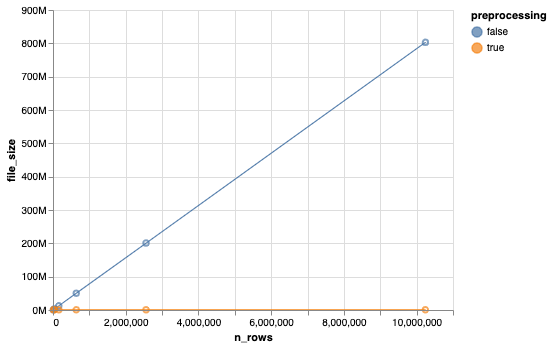

In [7]:
# json file size vs num of rows in data
chart = alt.Chart(file_size).encode(
    x='n_rows:Q',
    y=alt.Y('file_size:Q', axis=alt.Axis(format="~s")),
    color='preprocessing:N'
)
chart.mark_trail() + chart.mark_point()